In [18]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import yfinance as yf
import pickle

In [19]:
assets_list = ["BTC", 
"ETH",
"USDT",
"USDC",
"BNB",
"XRP",
"BUSD",
"ADA",
"SOL",
"DOGE",
"DOT",
"DAI",
"MATIC",
"WTRX",
"SHIB",
"HEX",
"TRX",
"AVAX",
"UNI1",
"WBTC",
"STETH",
"LEO",
"YOUC",
"LTC",
"LINK",
"ETC",
"ATOM",
"FTT",
"XLM",
"NEAR",
"CRO",
"XMR",
"ALGO",
"BCH",
"BTCB",
"LUNA1",
"FLOW",
"QNT",
"VET",
"APE3",
"TONCOIN",
"FIL",
"ICP",
"XCN1",
"CHZ",
"FRAX",
"HBAR",
"XTZ",
"MANA",
"SAND",
"WBNB",
"EOS",
"EGLD",
"THETA",
"AAVE",
"AXS",
"BIT1",
"OKB",
"USDP",
"BSV",
"KCS",
"TUSD",
"ZEC",
"MIOTA",
"BTT",
"XEC",
"HBTC",
"MKR",
"USDD",
"BTT2",
"HT",
"CAKE",
"HNT",
"GRT1",
"USDN",
"NEO",
"KLAY",
"FTM",
"SNX",
"PAXG",
"NEXO",
"RUNE",
"LDO",
"CRV",
"GT",
"DASH",
"ENJ",
"BAT",
"MV",
"COMP1",
"STX",
"KAVA",
"FEI",
"WAVES",
"ZIL",
"RVN",
"XAUT",
"MINA",
"LRC",
"XDC"
]

In [41]:
for i in assets_list:
    with open('pickles/'+str(i)+'-USD.pickle', 'rb') as handle:
          locals()[i] = pickle.load(handle)

In [42]:
df_tickers = pd.DataFrame()
for i in range(len(assets_list)):
    df_tickers = df_tickers.append(locals()[assets_list[i]]['Close']).reset_index(drop=True)
df_tickers['shortName']=assets_list
df_tickers = df_tickers.fillna(method='backfill')
df_tickers = df_tickers.fillna(method='ffill')
df_tickers.dropna(inplace=True)

In [43]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(df_tickers.T.iloc[:-1]).T

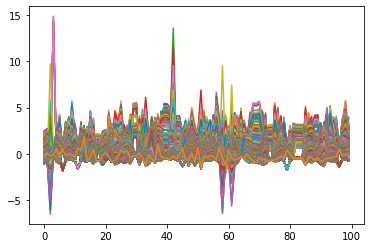

In [44]:
plt.plot(tickers_scaled);

  0%|          | 0/8 [00:00<?, ?it/s]

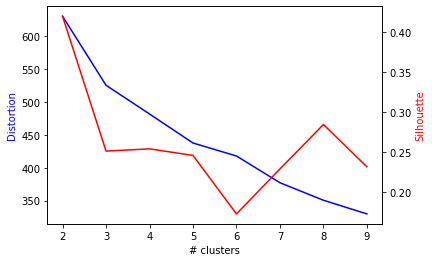

In [45]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [46]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_jobs=6)

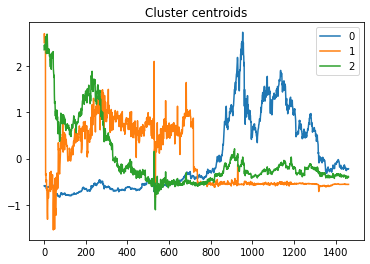

In [47]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [48]:
df_tickers['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(df_tickers.groupby('cluster')['shortName'].value_counts())

shortName
cluster shortName           
0       AAVE               1
        ADA                1
        APE3               1
        ATOM               1
        AXS                1
...                      ...
2       TUSD               1
        USDN               1
        USDP               1
        WTRX               1
        XCN1               1

[100 rows x 1 columns]

In [49]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[0:-2])
        ax[index].set_title(f"{row.shortName}-USD")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


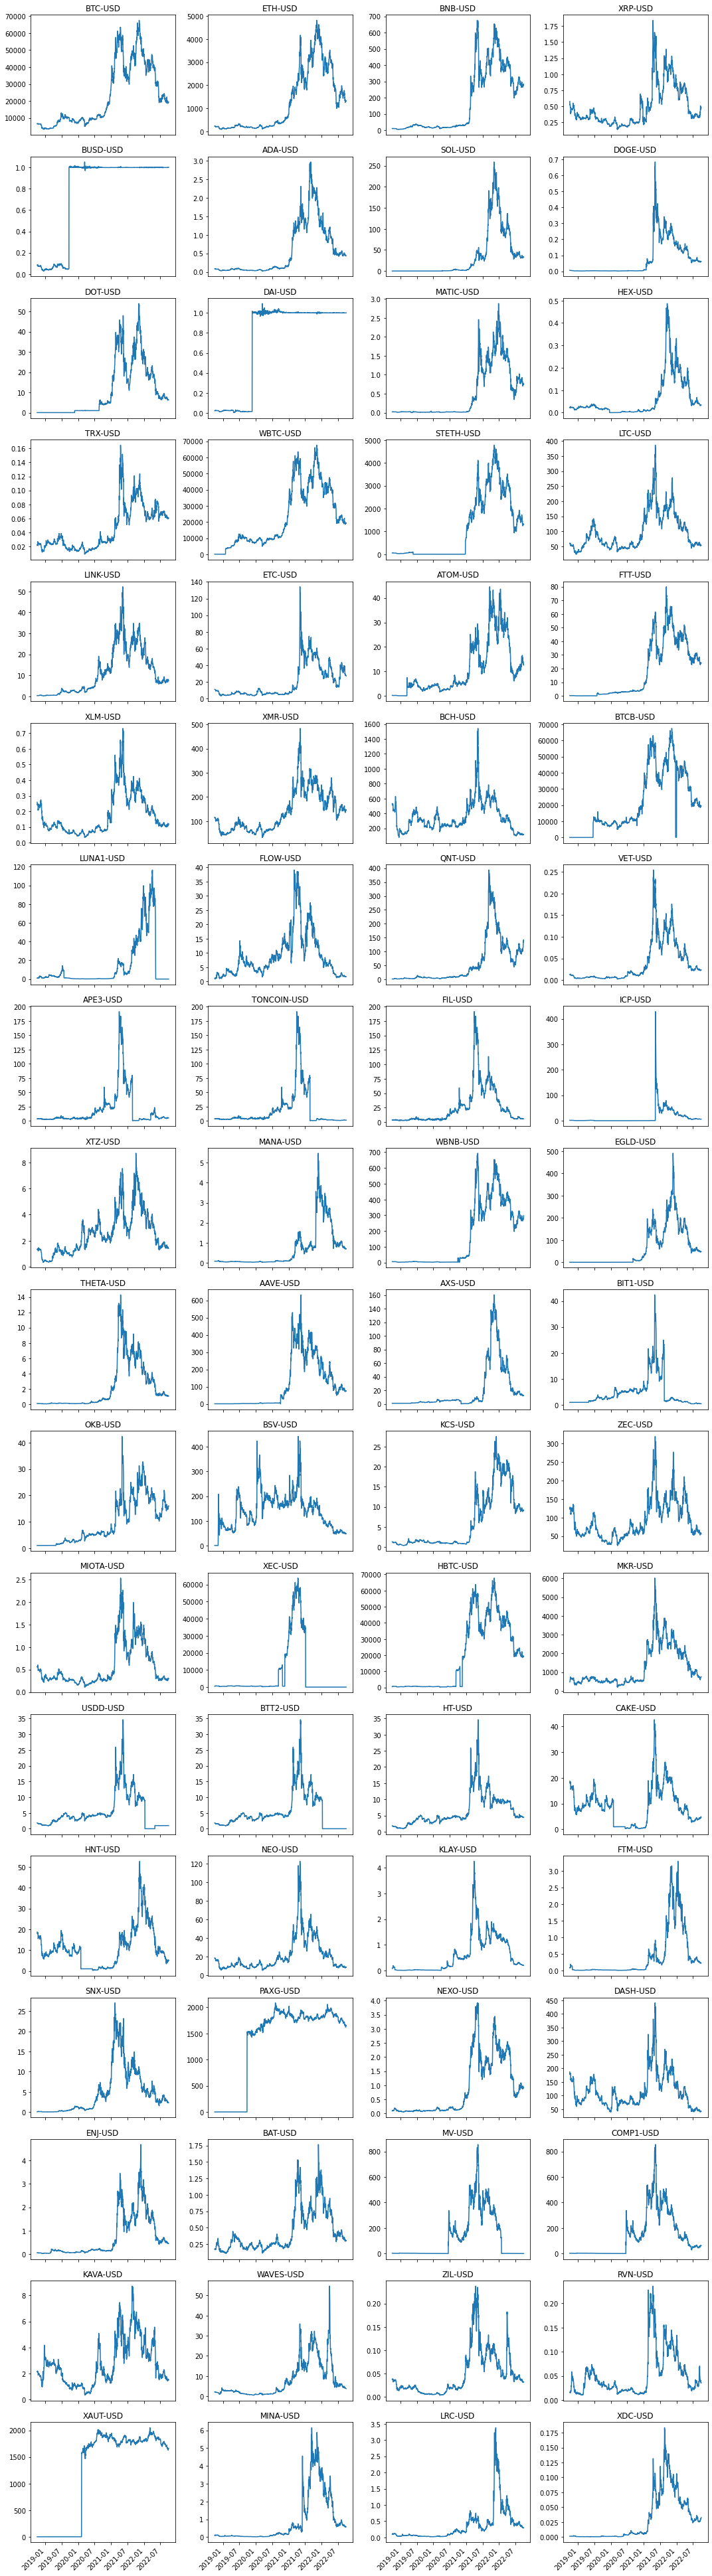

                          Cluster number: 1


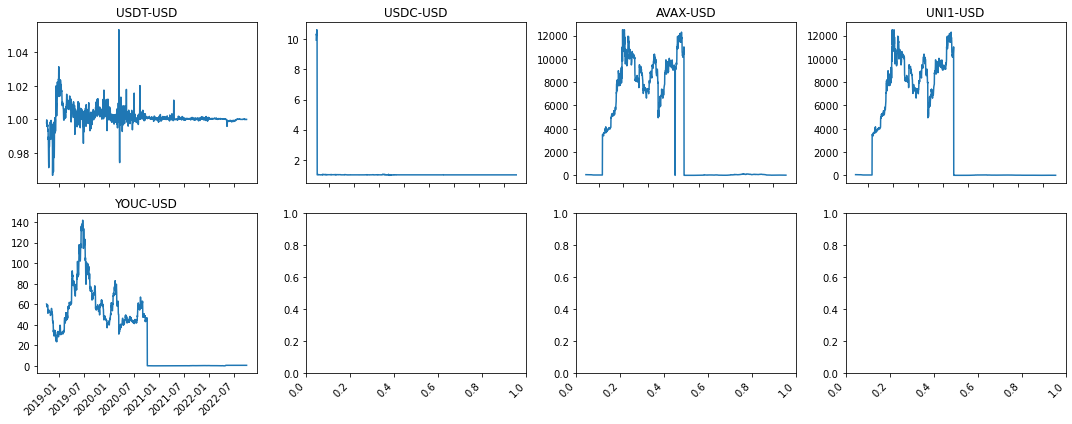

                          Cluster number: 2


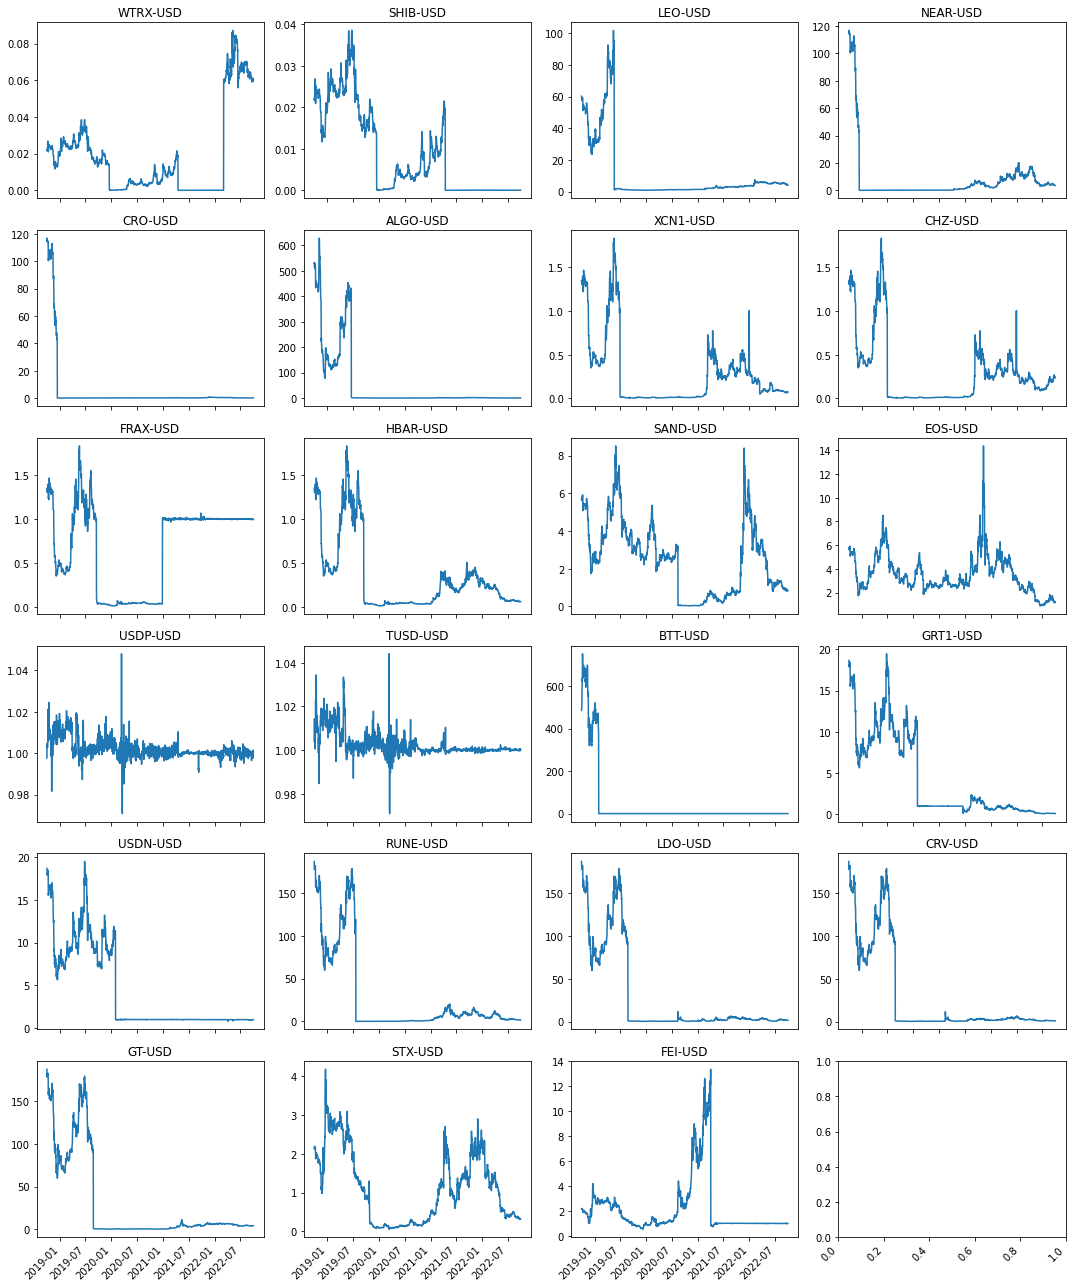

In [50]:
# df_tickers.drop(['shortName'], axis=1)
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(df_tickers[df_tickers.cluster==cluster])